Thanks to Tyler Folkman, Conner Leavitt,  and Pedro Marcelino for providing resources and advice on this assignment. I've provided links to Notebooks that I referenced for this assignment. 

https://www.kaggle.com/pmarcelino/comprehensive-data-exploration-with-python
https://github.com/tfolkman/byu_econ_applied_machine_learning/blob/master/lectures/Lecture_4_Linear_Regression_and_Evaluation.ipynb
https://github.com/tfolkman/byu_econ_applied_machine_learning/blob/master/lectures/Lecture_6_K_Nearest_Neighbors.ipynb

This is my submission for homework 2. I'll start by getting libraries installed and the data read in. I'll also create a separate vector containing the variable I'm trying to predict from the training data and make it its own vector 'sale_price'.

In [1]:
## import pandas an numpy for working with data
import pandas as pd
import numpy as np
## import scipy for working with data
from scipy import stats
from scipy.stats import norm
## import matplotlib and seaborn for plotting
import matplotlib.pyplot as plt
import seaborn as sns
## import learning curve
from sklearn.model_selection import learning_curve
## import make scorer
from sklearn.metrics import make_scorer
## suppress warnings
import warnings
warnings.filterwarnings('ignore')
## inline plots
%matplotlib inline

In [2]:
## import the training data as 'train'
train = pd.read_csv("C:/Users/camer/Desktop/Machine_Learning/train.csv")
## import the test data as 'test'
test = pd.read_csv("C:/Users/camer/Desktop/Machine_Learning/test.csv")
sale_price = train['SalePrice']

After talking with Conner, he told me that a good way to start a project like this is by getting a baseline model estimate. Don't mess with filling in missing data, don't worry about outliers, just drop everything that's not complete and run a model. That is what I'll do first: drop all variables with missing values, create dummy variables for all categorical variables, scale the data, and run a linear regression using stochastic gradient descent.

In [3]:
## import necessary libraries
from sklearn.linear_model import SGDRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler

In [4]:
## create 'nan_vars' which contain variables with missing values and drop those variables from the training data
nan_vars = train.columns[train.isnull().sum() > 0]
train_dropped = train.drop(nan_vars, axis = 1)
train_dropped = train_dropped.drop('SalePrice', axis = 1)

In [5]:
## create dummy variables for categorical variables in 'train_dropped'
train_dropped = pd.get_dummies(train_dropped)

In [6]:
## using 'StandardScaler', fit and transform the train data calling it 'scaled_train_dropped'
scaler = StandardScaler()
scaler.fit(train_dropped)
scaled_train_dropped = scaler.transform(train_dropped)

In [7]:
## create linear model using stochastic gradient descent, choosing a tolerance (when to stop iterating) and learning rate
linear_regression_model = SGDRegressor(tol=.0001, eta0=.001)
linear_regression_model.fit(scaled_train_dropped, sale_price)
predictions = linear_regression_model.predict(scaled_train_dropped)
mse = mean_squared_error(sale_price, predictions)
print("RMSE: {}".format(np.sqrt(mse)))

RMSE: 22714.43039624805


Okay, that RMSE is pretty bad, but it's a start. I can only improve from here (hopefully). Now, I'll go through and understand and clean up the data because there might be some valuable variables that would help my model if I clean them up a bit.

I want to start by examining our variable of interest: Sale Price.

In [8]:
## view summary stats of sale_price
sale_price.describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

Looks good, no outliers or min/max values that don't make sense. Pretty large standard deviation though.

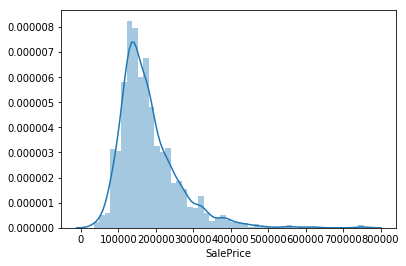

In [9]:
## view histogram of sale_price
sns.distplot(sale_price)

The distribution of sale price is skewed right pretty significantly, and has a strong peak. Although I care about Sale Price, I care more about the relationship between the other variables in the data and sale price. My plan will be to determine which variables are most strongly correlated with Sale price, and use those in my models. Variables that are not strongly correlated with Sale Price may make my model perform poorly if included. Once I determine the strength of relationships in the data, I'll drop some variables that are not going to be very meaningful and I'll clean up/analyze the remaining data. I'll make a heatgrid to start examining the variables' relationships.

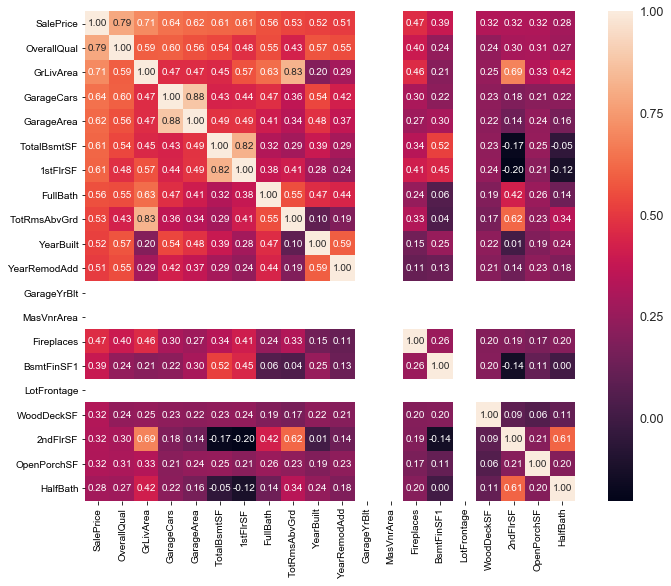

In [10]:
## saleprice correlation matrix, make a larger space for the plot to fill, look at variables with 20 strongest correlations
f, ax = plt.subplots(figsize=(12, 9))
corrmat = train.corr()
k = 20
cols = corrmat.nlargest(k, 'SalePrice')['SalePrice'].index
cm = np.corrcoef(train[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

There are 11 variables with medium to fairly strong correlations with Sale Price. We can also see that some variables, like GarageArea and GarageCars as well as totalbsmtSF and 1stFlrSF are very highly correlated with each other so some multicollinearity might be occurring. Moving forward, I will only keep one variable from these pairs, and it will be whichever one is most strongly correlated with sale price. A pairplot can help visualize the relationship that Sale Price has with some of the strongest correlated variables.

In [11]:
## drop variables that are highly correlated with other features
train = train.drop(['GarageArea', '1stFlrSF'], axis = 1)

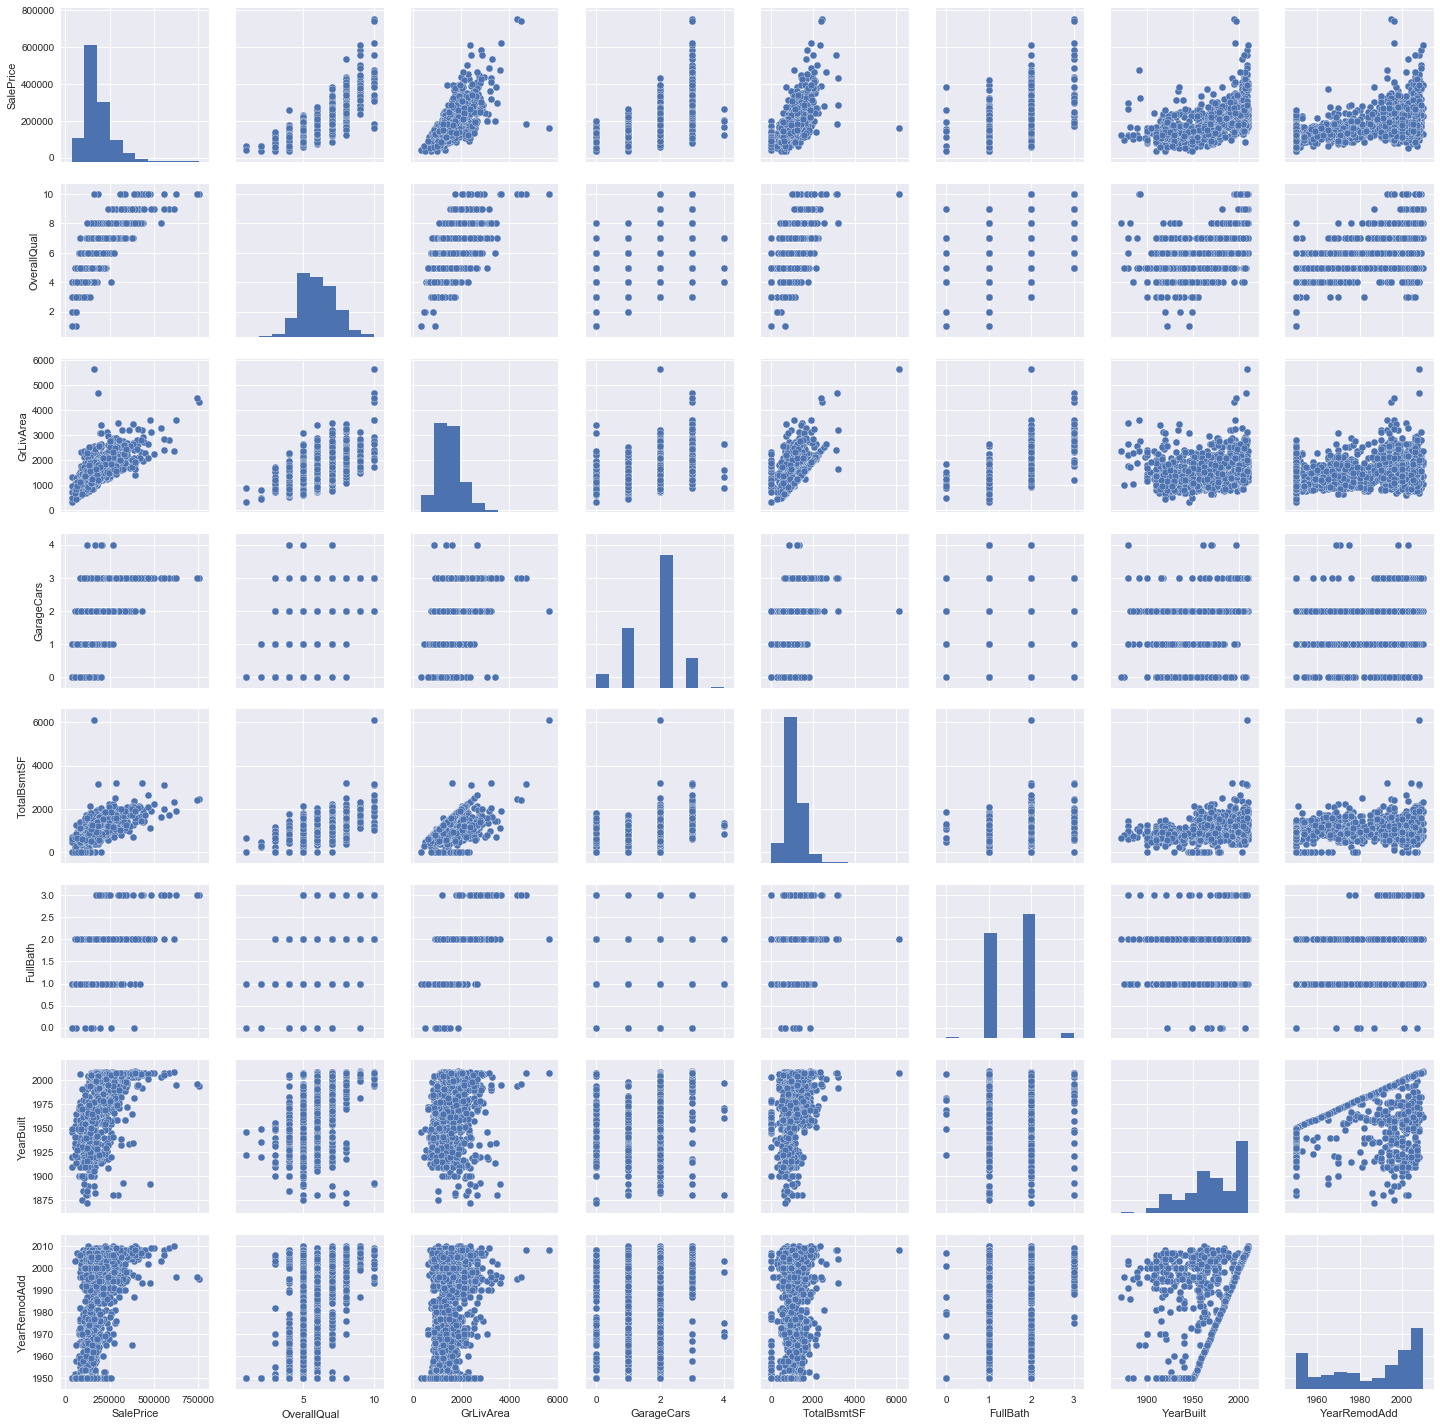

In [12]:
#pairplot
sns.set()
cols = ['SalePrice', 'OverallQual', 'GrLivArea', 'GarageCars', 'TotalBsmtSF', 'FullBath', 'YearBuilt', 'YearRemodAdd']
sns.pairplot(train[cols], size = 2.5)
plt.show()

There is a fairly strong relationship between sale price and each of these variables. The relationships with YearBuilt and YearRemodAdd are very similar, as well as TotalBsmtSF and GRLivArea. Overall quality has a very neat relationship with Sale Price, one that is strongly positive and slightly exponential. I will look at polynomial features later.

These variables all look very promising, and I hope that they will produce a good model. Before getting to that though, I need to work to clean up the data and fill in missing values.

I want to get a look at the data first.

In [13]:
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


I can see right off the bat that the 'Id' variable doesn't need to be there.

In [14]:
## remove 'Id' variable
train = train.drop('Id', axis = 1)

I'll get a look at missing values next. Pedro suggests that a good philosophy when handling missing values is to drop the variables that have more than 15% of their data missing. Part of this is subjective, because we should consider whether we would miss the variables that we drop. In this case, we should consider whether these are factors that anyone would reasonably consider when buying a home. I haven't purchased a home before, so I'm not sure I could judge effectively what matters when purchasing a house. I'll decide which variables to drop based on their correlations with the variable of interest.

In [15]:
## for each variable with missing data, sum the number of missing values, and sort in descending order
train.isnull().sum().sort_values(ascending=False).head(25)

PoolQC          1453
MiscFeature     1406
Alley           1369
Fence           1179
FireplaceQu      690
LotFrontage      259
GarageCond        81
GarageType        81
GarageYrBlt       81
GarageFinish      81
GarageQual        81
BsmtExposure      38
BsmtFinType2      38
BsmtCond          37
BsmtQual          37
BsmtFinType1      37
MasVnrArea         8
MasVnrType         8
Electrical         1
LotConfig          0
YearRemodAdd       0
MSZoning           0
Foundation         0
ExterCond          0
ExterQual          0
dtype: int64

There are a fair number of variables with missing values, although for some the missing values may represent an actual value. For example, an NA in the PoolQC (pool quality) variable means that the house doesn't have a pool. However, a variable like PoolQC that only has 7 actual values, should probably be dropped since it's not adding anything to the data. We would be better off which one variable indicating whether or not a house has a pool.

In [16]:
## create 'pool' variable: a dummy variable for whether the house has a pool or not since there are so few houses with a pool
train['Pool'] = 0
# replace the 'Pool' variable with a 1 for the houses where pool area is > 0, i.e. the houses that have a pool
train.loc[train['PoolArea'] > 0, 'Pool'] = 1
#drop the 'PoolArea' and 'PoolQC' variables
train = train.drop(['PoolArea','PoolQC'], axis=1)

MiscFeature indicates features such as elevators, garages, and tennis courts that are not covered anywhere else in the data. There are a lof of missing values for this variable, but it seems important because these feature may add a lot of value to a house. It's also easy to fill in NA values because they simply represent a house with no extra features.

In [17]:
## replace the missing values in 'MiscFeature' with 'None'
train['MiscFeature'] = train.MiscFeature.fillna('None')

Similarly, it is easy to replace missing 'Alley' variables because they represent no access. I'll determine later whether there is a significant enough correlation to justify keeping 'Alley' in the data. With the following variables, I will reassess correlations between the variables in the data and Sale Price to determine which variables to keep.

In [18]:
## replace missing 'Alley' values with 'No_Access'
train['Alley'] = train.Alley.fillna('None')

The 'Fence' variable indicates how much privacy a fence gives as well as the type of material used in the fence. NA values indicate that there is no fence.

In [19]:
## replace missing 'Fence' values with 'No_Fence'
train['Fence'] = train.Fence.fillna('None')

The 'FireplaceQu' variable indicates the quality of a house's fireplace, with NA values indicating a house has no fireplace.

In [20]:
## replace missing 'FireplaceQu' values with 'No_FP'
train['FireplaceQu'] = train.FireplaceQu.fillna('None')

The 'LotFrontage' variable represents the number of linear feet of street connected to the property. I'll just replace missing values with zero.

In [21]:
## replace missing values in 'LotFrontage' with 0
train['LotFrontage'] = train.LotFrontage.fillna(0)

All of the missing values for the garage variables ('GarageCond', 'GarageType', 'GarageYrBlt', 'GarageFinish', 'GarageQual') indicate a house with no garage. I'll replace the missing values with 'No_garage'.

In [22]:
## create 'g_vars' which contains the names of all garage variables
g_vars = ['GarageCond', 'GarageType', 'GarageYrBlt', 'GarageFinish', 'GarageQual']
## loop over each garage variable and replace missing values with 'No_garage'
for var in g_vars:
    train[var] = train[var].fillna('No_Garage')

All of the 'Bsmt' variables represent characteristics of basements. NA values for all of the 'Bsmt' variables represent a home with no basement. So, each of these variables should have the same number of missing values, but they don't. It looks like there might be one home with values for 'BsmtFinType1', 'BsmtCond', and 'BsmtQual' but not for 'BsmtExposure', 'BsmtFinType2'.

In [23]:
## view differing null observation for basement variables
train.loc[train['BsmtExposure'].isnull()][['BsmtExposure', 'BsmtFinType2', 'BsmtFinType1', 'BsmtCond', 'BsmtQual']]

,BsmtExposure,BsmtFinType2,BsmtFinType1,BsmtCond,BsmtQual
17,NaN,NaN,NaN,NaN,NaN
39,NaN,NaN,NaN,NaN,NaN
90,NaN,NaN,NaN,NaN,NaN
102,NaN,NaN,NaN,NaN,NaN
156,NaN,NaN,NaN,NaN,NaN
182,NaN,NaN,NaN,NaN,NaN
259,NaN,NaN,NaN,NaN,NaN
342,NaN,NaN,NaN,NaN,NaN
362,NaN,NaN,NaN,NaN,NaN
371,NaN,NaN,NaN,NaN,NaN


Observation 948 has values in all the basement variables except 'BsmtExposure'. The value 'No' seems most likely to fit this observation based on the other data in the Bsmt variables. I'll double check the number of each type of BsmtExposure, and replace it with the most common type if it's not 'No'.

In [24]:
## replace house in row 948 'BsmtExposure' missing value with 'No'
print(train.BsmtExposure.value_counts())
train.loc[948, 'BsmtExposure'] = 'No'

No    953
Av    221
Gd    134
Mn    114
Name: BsmtExposure, dtype: int64


In [25]:
## view the basement columns where 'BsmtFinType2' is NA
train.loc[train['BsmtFinType2'].isnull()][['BsmtExposure', 'BsmtFinType2', 'BsmtFinType1', 'BsmtCond', 'BsmtQual']]

,BsmtExposure,BsmtFinType2,BsmtFinType1,BsmtCond,BsmtQual
17,NaN,NaN,NaN,NaN,NaN
39,NaN,NaN,NaN,NaN,NaN
90,NaN,NaN,NaN,NaN,NaN
102,NaN,NaN,NaN,NaN,NaN
156,NaN,NaN,NaN,NaN,NaN
182,NaN,NaN,NaN,NaN,NaN
259,NaN,NaN,NaN,NaN,NaN
332,No,NaN,GLQ,TA,Gd
342,NaN,NaN,NaN,NaN,NaN
362,NaN,NaN,NaN,NaN,NaN


Again, a house with other basement variables has a missing value in one of the basement variables, in this case 'BsmtFinType2'.
However, this variable represents the finished level of the other area in the basement (if other areas are present) in this case it looks like part of the basement is finished, and part is not, which is represented by NA, which is equivalent to 'No_basement'.

The rest of the NA values for basement variables can be replaced with 'No_basement'

In [26]:
## store basement variables in 'b_vars', replace their missing values with 'No_Basement'
b_vars = ['BsmtExposure', 'BsmtFinType2', 'BsmtFinType1', 'BsmtCond', 'BsmtQual']
for var in b_vars:
    train[var] = train[var].fillna('No_Basement')

The 'MasVnr-' variables represent the masonry veneer type and area in square feet. Missing values for the type variable with be replaced with 'No_ven' and missing values for the area variable will be replaced with 0. These variables seem likely to be dropped later, but I'll replace the missing data anyway.

In [27]:
## replace NA values in 'MasVnr-' variables with 'No_Ven' and 0
train['MasVnrType'] = train.MasVnrType.fillna('No_Ven')
train['MasVnrArea'] = train.MasVnrArea.fillna(0)

The final variable with missing data is the 'Electrical' variable which tells the type of electrical system.

In [28]:
## view count of entries in Electrical
train.Electrical.value_counts()

SBrkr    1334
FuseA      94
FuseF      27
FuseP       3
Mix         1
Name: Electrical, dtype: int64

The most common type of electrical system by far is 'SBrkr' so I'll replace the missing electrical variable with that.

In [29]:
## replace electrical NA with 'SBrkr'
train['Electrical'] = train.Electrical.fillna('SBrkr')

That takes care of all missing values. However, not all of these variables are going to be useful. If I were to generate dummy variables now and run a model (I have in the past) I would get just under 400 variables and my model would perform very poorly. So, I'll examine correlations again while considering home features that seem most important when buying a home, and I'll drop some variables that I don't think will contribute to my model.

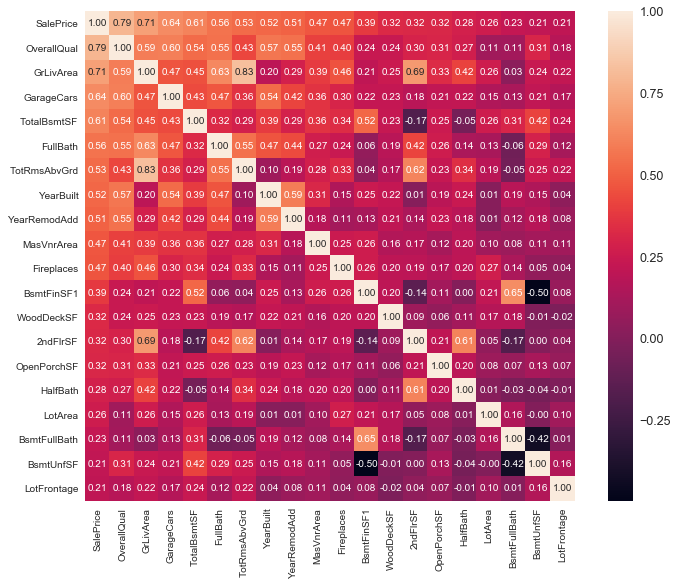

In [30]:
## saleprice correlation matrix, make a larger space for the plot to fill, look at variables with 20 strongest correlations
f, ax = plt.subplots(figsize=(12, 9))
corrmat = train.corr()
k = 20
cols = corrmat.nlargest(k, 'SalePrice')['SalePrice'].index
cm = np.corrcoef(train[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

20 variables is just an arbitrary number than I chose, but you can see that only 8 variables have a correlation with Sale Price over 0.5.

In [31]:
## sort and display each variable's correlation with SalePrice in descending order
train.corrwith(sale_price).sort_values(ascending = False)

SalePrice        1.000000
OverallQual      0.790982
GrLivArea        0.708624
GarageCars       0.640409
TotalBsmtSF      0.613581
FullBath         0.560664
TotRmsAbvGrd     0.533723
YearBuilt        0.522897
YearRemodAdd     0.507101
MasVnrArea       0.472614
Fireplaces       0.466929
BsmtFinSF1       0.386420
WoodDeckSF       0.324413
2ndFlrSF         0.319334
OpenPorchSF      0.315856
HalfBath         0.284108
LotArea          0.263843
BsmtFullBath     0.227122
BsmtUnfSF        0.214479
LotFrontage      0.209624
BedroomAbvGr     0.168213
ScreenPorch      0.111447
Pool             0.093708
MoSold           0.046432
3SsnPorch        0.044584
BsmtFinSF2      -0.011378
BsmtHalfBath    -0.016844
MiscVal         -0.021190
LowQualFinSF    -0.025606
YrSold          -0.028923
OverallCond     -0.077856
MSSubClass      -0.084284
EnclosedPorch   -0.128578
KitchenAbvGr    -0.135907
dtype: float64

In particular, the MoSold-MSSubClass variables are very weakly correlated with Sale Price. I'll keep the pool variable since a pool should add significant value to an individual home. Something that I find very interesting is that the OverallQual variable and the OverallCond variable, which represent very similar things, have very different correlations with sale price. I wonder if there were some differences in the way these variables were calculated or inputted that makes them so different.

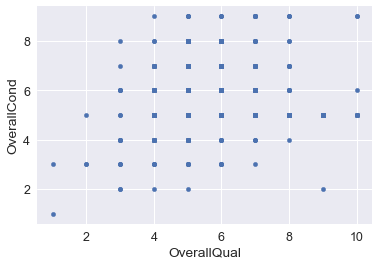

In [32]:
## scatter plot with 'OverallQual' and 'OverallCond'
train.plot.scatter(x = 'OverallQual', y = 'OverallCond')

There is a somewhat positive relationship, but it's not very strong and there is a lot of variation. Thankfully overall quality is strongly correlated with sale price so hopefully it captures the relationship between house quality and price.

In [33]:
train = train.drop(['MoSold', '3SsnPorch', 'BsmtFinSF2', 'BsmtHalfBath',
                    'MiscVal', 'LowQualFinSF', 'YrSold', 'OverallCond', 'MSSubClass'], axis = 1)

The 'OverallQual' variable is actually a categorical variable represented numerically, but the size of the numbers is indicative of the quality, so the levels actually make sense. It should work left as a numeric variable.

Now that all my missing values are filled in and some of the less useful features have been dropped, I want to see how many variables I have after creating dummy variables for all the categorical variables in the data.

In [34]:
## create dummy variables and look at dimensions of data
train = pd.get_dummies(train)
train.shape

(1460, 386)

Unfortunately, removing those variables really didn't reduce my feature set size by a lot. I have 386 variables in my dataset after creating all the dummy variables. I'll check which variables have a correlation with Sale Price that is larger than an absolute value of .10.

In [35]:
## create var_corrs which is the correlations between every x variable and sale price sorted highest to lowest
var_corrs = train.corrwith(sale_price).sort_values(ascending = False)

In [36]:
## create sig_vars, containing variables with correlation absolute values greater than 0.10
sig_vars = var_corrs[abs(var_corrs) > 0.10].index

In [37]:
## select sig_vars out of train data
train = train[sig_vars]

In [38]:
## view dimensions of train data
train.shape

(1460, 150)

Now I have 150 variables in the data, all of which have a correlation with Sale Price over an absolute value of 0.10.

In all this data, there isn't a variable representing the total square feet in a house. I'll make one, and drop the other square feet variables to avoid multicollinearity.

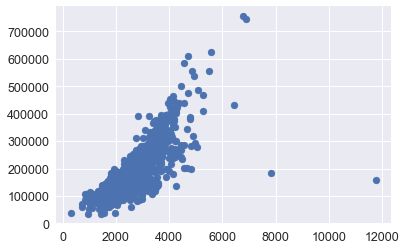

In [39]:
## create 'TotalSF' which is the sum of basement, 1st floor, and 2nd floor square footage and plot 'SalePrice' by 'TotalSF'
train['TotalSF'] = train['TotalBsmtSF'] + train['GrLivArea']
train = train.drop(['TotalBsmtSF', 'GrLivArea'], axis = 1)
plt.scatter(train['TotalSF'], train['SalePrice'])

This relationship looks really strong, but there are two very significant outliers. They do not fit the overall trend, so I'm going to drop them.

In [40]:
## view the two homes that are outliers
train[train['TotalSF'] > 7500]

,SalePrice,OverallQual,GarageCars,FullBath,BsmtQual_Ex,TotRmsAbvGrd,YearBuilt,YearRemodAdd,KitchenQual_Ex,Foundation_PConc,...,HeatingQC_TA,Foundation_CBlock,GarageType_Detchd,MasVnrType_None,GarageFinish_Unf,BsmtQual_TA,FireplaceQu_None,KitchenQual_TA,ExterQual_TA,TotalSF
523,184750,10,3,3,1,11,2007,2008,1,1,...,0,0,0,0,0,0,0,0,0,7814
1298,160000,10,2,2,1,12,2008,2008,1,1,...,0,0,0,0,0,0,0,0,0,11752


In [41]:
## drop the outlier houses from the data, and drop variable of interest. recreate 'sale_price' since number of obs has changed
train = train.drop([523, 1298])
sale_price = train['SalePrice']
train = train.drop('SalePrice', axis = 1)

Now the test data is all clean, I'm going to start creating the models. I'll scale the data first so that it's easier for gradient descent to converge. Then, I want to split the data in train and test sets and run RCV for a bunch of different learning rates to find the best one on average, then run a linear regression via stochastic gradient decent.

In [42]:
## scale the training data, call it sc_train
scaler.fit(train)
sc_train = scaler.transform(train)

In [43]:
## split data into training and testing sets
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(sc_train, sale_price, test_size=0.3)

In [44]:
## import RCV, iterate over different learning rates to find best choice as to maxmize negative MSE
from sklearn.model_selection import RandomizedSearchCV

param_dist = {"eta0": [ .001, .003, .01, .03, .1, .3, 1, 3]}

linear_regression_model = SGDRegressor(tol=.0001)

n_iter_search = 8
random_search = RandomizedSearchCV(linear_regression_model, param_distributions=param_dist,
                                   n_iter=n_iter_search, cv=3, scoring='neg_mean_squared_error')
random_search.fit(X_train, y_train)

print("Best Parameters: {}".format(random_search.best_params_))
print("Best Negative MSE: {}".format(random_search.best_score_))

Best Parameters: {'eta0': 0.01}
Best Negative MSE: -707308748.662867


So that MSE is SUPER BAD. But it gave me a learning rate of .003 so that's what I'll use in a regular linear regression model.

In [45]:
linear_regression_model = SGDRegressor(tol=.0001, eta0=.001)
linear_regression_model.fit(X_train, y_train)
train_predictions = linear_regression_model.predict(X_train)
test_predictions = linear_regression_model.predict(X_test)

train_mse = mean_squared_error(y_train, train_predictions)
test_mse = mean_squared_error(y_test, test_predictions)

print("Train MSE: {}".format(train_mse))
print("Test MSE: {}".format(test_mse))

Train MSE: 517209483.89572567
Test MSE: 550493191.1506824


In [46]:
## specify tolerance and learning rate for a linear regression, predict based on the regression, compare differences for RMSE
linear_regression_model = SGDRegressor(tol=.0001, eta0=.001)
linear_regression_model.fit(sc_train, sale_price)
predictions = linear_regression_model.predict(sc_train)
mse = mean_squared_error(sale_price, predictions)
print("RMSE: {}".format(np.sqrt(mse)))

RMSE: 22570.254760104635


That RMSE is still too high. I remember seeing what looked like exponential relationships between some of the variables and sale price, so I'll try a model with polynomial features. 

In [47]:
## import polynomial features, generate squared variables, and transform the data calling it scaled_poly_train
from sklearn.preprocessing import PolynomialFeatures
poly = PolynomialFeatures(2, include_bias=False)
poly_train = poly.fit_transform(train)
scaled_poly_train = scaler.fit_transform(poly_train)

In [48]:
## split data into training and testing sets using polynomial data
X_train, X_test, y_train, y_test = train_test_split(scaled_poly_train, sale_price, test_size=0.3)

In [49]:
## using RCV, run a bunch of model iterations to find best choice of learning rate based on 3 folds and negative MSE scoring
from sklearn.model_selection import RandomizedSearchCV

param_dist = {"eta0": [ .0001, .0003, .001, .003, .01, .03, .1, .3, 1, 3]}

linear_regression_model = SGDRegressor(tol=.0001)

n_iter_search = 8
random_search = RandomizedSearchCV(linear_regression_model, param_distributions=param_dist,
                                   n_iter=n_iter_search, cv=3, scoring='neg_mean_squared_error')
random_search.fit(X_train, y_train)

print("Best Parameters: {}".format(random_search.best_params_))
print("Best Negative MSE: {}".format(random_search.best_score_))

Best Parameters: {'eta0': 0.0003}
Best Negative MSE: -150141451744.18414


In [50]:
linear_regression_model = SGDRegressor(tol=.0001, eta0=.0003)
linear_regression_model.fit(X_train, y_train)
train_predictions = linear_regression_model.predict(X_train)
test_predictions = linear_regression_model.predict(X_test)

train_mse = mean_squared_error(y_train, train_predictions)
test_mse = mean_squared_error(y_test, test_predictions)

print("Train MSE: {}".format(train_mse))
print("Test MSE: {}".format(test_mse))

Train MSE: 31037521.03495278
Test MSE: 245066876125.255


In [51]:
## source: http://scikit-learn.org/0.15/auto_examples/plot_learning_curve.html
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes, scoring=make_scorer(mean_squared_error))
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

<module 'matplotlib.pyplot' from 'C:\\Users\\camer\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

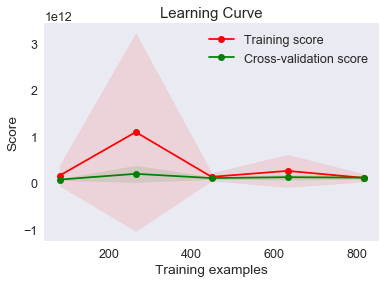

In [52]:
plot_learning_curve(linear_regression_model, "Learning Curve", X_train, y_train, cv=5)

In [53]:
## run model using best learning rate on polynomial data
linear_regression_model = SGDRegressor(tol=.0001, eta0 = 0.0001)
linear_regression_model.fit(scaled_poly_train, sale_price)
predictions = linear_regression_model.predict(scaled_poly_train)
mse = mean_squared_error(sale_price, predictions)
print("RMSE: {}".format(np.sqrt(mse)))

RMSE: 4949.474932716819


The RMSE when using the full polynomial training data set isn't horrible, I'm only off on average by about $4000, but when the data is split into training and test sets, the RMSE blows up. Based on the learning curve graph, I have no idea what's going on. I'll try using regularization to help.

Note for Conner: I'd love to meet and talk about what's going on with my analysis, because I've been getting extremely different learning curve graphs everytime I run my notebook.

In [54]:
## import ENCV, run different l1 ratios and alphas, fit to the train data, make predictions, and compare MSE for train vs. test
from sklearn.linear_model import ElasticNetCV
clf = ElasticNetCV(l1_ratio=[.1, .5, .7, .9, .95, .99, 1], alphas=[.1, 1, 10])
clf.fit(X_train, y_train)
train_predictions = clf.predict(X_train)
test_predictions = clf.predict(X_test)
print("Train MSE: {}".format(mean_squared_error(y_train, train_predictions)))
print("Test MSE: {}".format(mean_squared_error(y_test, test_predictions)))

Train MSE: 55972083.66087573
Test MSE: 716364745.277582


Regularization was ineffective at lowering the RMSE.

And finally, I'll give KNN a go. I'll use the original scaled data since the curse of dimensionality starts becoming relevent as you add more variables, and the polynomial data has many more variables than the original scaled data.

In [55]:
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import f1_score, classification_report, accuracy_score, mean_squared_error

In [56]:
X_train, X_test, y_train, y_test = train_test_split(sc_train, sale_price, test_size=0.20)
reg = KNeighborsRegressor()
gridsearch = GridSearchCV(reg, {"n_neighbors": [1, 3, 5, 7, 9, 11], "weights": ['uniform', 'distance'], 
                                'p': [1, 2, 3]}, scoring='neg_mean_squared_error')
gridsearch.fit(X_train, y_train)
print("Best Params: {}".format(gridsearch.best_params_))
y_pred_train = gridsearch.predict(X_train)
y_pred_test = gridsearch.predict(X_test)
print("Train MSE: {}\tTest MSE: {}".format(mean_squared_error(y_train, y_pred_train),
                                           mean_squared_error(y_test, y_pred_test)))

Best Params: {'n_neighbors': 9, 'p': 1, 'weights': 'distance'}
Train MSE: 0.0	Test MSE: 1116365025.536767


Unfortunately KNN regression produces a model that is completely overfitted.

The best model that I found was the polynomial feature linear regression. I'll take a look at which features were most significant in determining house price.

Now I'm done with the models, I just need to clean the test data, generate my predictions, and submit to Kaggle.

I dropped several variables from the original train data and created a couple more so I'll do that in the test data as well. I should be able to just compare the columns in the train data before transforming it to the columns in test data and remove columns from the test data so that the train and test data are equivalent on features before transformations. Then I can apply the same transformations to the test data as I did to the training data.

In [57]:
## drop variables that are highly correlated with other features
test = test.drop(['GarageArea', '1stFlrSF'], axis = 1)

In [58]:
## remove 'Id' variable
test = test.drop('Id', axis = 1)

In [59]:
## create 'pool' variable: a dummy variable for whether the house has a pool or not since there are so few houses with a pool
test['Pool'] = 0
# replace the 'Pool' variable with a 1 for the houses where pool area is > 0, i.e. the houses that have a pool
test.loc[test['PoolArea'] > 0, 'Pool'] = 1
#drop the 'PoolArea' and 'PoolQC' variables
test = test.drop(['PoolArea','PoolQC'], axis=1)

In [60]:
test = test.drop(['MoSold', '3SsnPorch', 'BsmtFinSF2', 'BsmtHalfBath',
                    'MiscVal', 'LowQualFinSF', 'YrSold', 'OverallCond', 'MSSubClass'], axis = 1)
test['TotalBsmtSF'] = test.TotalBsmtSF.fillna(test.TotalBsmtSF.mean())

In [61]:
test['TotalSF'] = test['TotalBsmtSF'] + test['GrLivArea']

In [62]:
test = pd.get_dummies(test)
test.shape

(1459, 258)

In [63]:
test_cols = test.columns
train_cols = train.columns
diff_cols = np.setdiff1d(test_cols, train_cols)

In [64]:
## create vectors containing columns from train and test data, get columns in test but not train, then drop them from test
## create 'TotalSF' which is the sum of basement, 1st floor, and 2nd floor square footage and plot 'SalePrice' by 'TotalSF'
test = test.drop(diff_cols, axis = 1)

In [65]:
test_cols = test.columns
np.setdiff1d(test_cols, train_cols)

array([], dtype=object)

In [66]:
## display variables with missing values in descending order
test.isnull().sum().sort_values(ascending=False).head(15)

LotFrontage             227
MasVnrArea               15
BsmtFullBath              2
BsmtUnfSF                 1
BsmtFinSF1                1
GarageCars                1
Exterior1st_MetalSd       0
Exterior1st_VinylSd       0
Neighborhood_MeadowV      0
Neighborhood_NAmes        0
Neighborhood_NoRidge      0
Neighborhood_NridgHt      0
Neighborhood_OldTown      0
Neighborhood_Sawyer       0
Neighborhood_Somerst      0
dtype: int64

In [67]:
## replace NA values in 'LotFrontage' with 0
test['LotFrontage'] = test.LotFrontage.fillna(0)

In [68]:
## replace NA veneer area with 0
test['MasVnrArea'] = test.MasVnrArea.fillna(0)

In [69]:
print(test.BsmtFullBath.value_counts())
test['BsmtFullBath'] = test.BsmtFullBath.fillna(0)

0.0    849
1.0    584
2.0     23
3.0      1
Name: BsmtFullBath, dtype: int64


In [70]:
avg_cars = test['GarageCars'].mean()
test['GarageCars'] = test.GarageCars.fillna(avg_cars)

In [71]:
avg_sf1 = test.BsmtFinSF1.mean()
test['BsmtFinSF1'] = test.BsmtFinSF1.fillna(avg_sf1)
avg_unf = test.BsmtUnfSF.mean()
test['BsmtUnfSF'] = test.BsmtUnfSF.fillna(avg_unf)

In [72]:
test.isnull().sum()

LotFrontage              0
LotArea                  0
OverallQual              0
YearBuilt                0
YearRemodAdd             0
MasVnrArea               0
BsmtFinSF1               0
BsmtUnfSF                0
2ndFlrSF                 0
BsmtFullBath             0
FullBath                 0
HalfBath                 0
BedroomAbvGr             0
KitchenAbvGr             0
TotRmsAbvGrd             0
Fireplaces               0
GarageCars               0
WoodDeckSF               0
OpenPorchSF              0
EnclosedPorch            0
ScreenPorch              0
TotalSF                  0
MSZoning_C (all)         0
MSZoning_RL              0
MSZoning_RM              0
Alley_Grvl               0
LotShape_IR1             0
LotShape_IR2             0
LotShape_Reg             0
LandContour_Bnk          0
                        ..
Electrical_FuseA         0
Electrical_FuseF         0
Electrical_SBrkr         0
KitchenQual_Ex           0
KitchenQual_Fa           0
KitchenQual_Gd           0
K

In [73]:
poly = PolynomialFeatures(2, include_bias=False)
poly_test = poly.fit_transform(test)
scaled_poly_test = scaler.fit_transform(poly_test)
print(scaled_poly_test.shape)
print(scaled_poly_train.shape)

(1459, 8384)
(1458, 11174)


In [74]:

predictions = linear_regression_model.predict(scaled_poly_test)
print(predictions)

ValueError: shapes (1459,8384) and (11174,) not aligned: 8384 (dim 1) != 11174 (dim 0)